# `tfcausalimpact`

After looking at `causalpy`, let's see how `tfcausalimpact` compares. What I like about this is that it isn't that finnicky about the index type and this implementation uses a Bayesian Structural Time Series model which I can wrap my head around.

A BSTS model takes on a specific form of our happy State Space model:

$$
\begin{aligned}
\text{observation} \quad y_t & = Z_t\alpha_t + \beta X_t + G_t\epsilon_t, \quad &\epsilon_t \sim N(0, H_t)\\
\text{state} \quad \alpha_{t+1} & = T_t \alpha_t + R_t \eta_t, \quad &\eta_t \sim N(0, Q_t)
\end{aligned}
$$

Note the $\beta X_t$ term for the regressors.

In [5]:
#!pip install tfcausalimpact

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from causalimpact import CausalImpact

## Brexit Example

Note: `tfcausalimpact` assumes the `y` variable is the first column in the dataframe and all subsequent columns are covariates.

In [7]:
import causalpy as cp

df = (
    cp.load_data("brexit")
    .loc[lambda x: x.Time >= "2009-01-01"]
    # manual exclusion of some countries
    .drop(["Japan", "Italy", "US", "Spain", "Portugal"], axis=1)
    .set_index('Time')
)
df.head()

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Iceland,Luxemburg,Netherlands,New_Zealand,Norway,Sweden,Switzerland,UK
Time,,,,,,,,,,,,,,,,
2009-01-01,3.84048,0.802836,0.94117,16.93824,4.50096,0.51052,5.05450,6.63471,5.18157,0.114836,1.634391,0.47336,7.78753,10.32220,1.476532,4.61881
2009-04-01,3.86954,0.796545,0.94162,16.75340,4.41372,0.50829,5.05375,6.64530,5.16171,0.116259,1.634432,0.47916,7.71903,10.32867,1.485509,4.60431
2009-07-01,3.88115,0.799937,0.95352,16.82878,4.42898,0.51299,5.06237,6.68237,5.24132,0.118747,1.640982,0.48188,7.72400,10.32328,1.502506,4.60722
2009-10-01,3.91028,0.803823,0.96117,17.02503,4.43300,0.50903,5.09832,6.73155,5.22482,0.119302,1.650866,0.48805,7.72812,10.37107,1.515139,4.62152
2010-01-01,3.92716,0.800510,0.96615,17.23041,4.47128,0.51413,5.11625,6.78621,4.91128,0.121414,1.647748,0.49349,7.87891,10.64833,1.525864,4.65380


In [8]:
# get useful country lists
target_country = "UK"
other_countries = list(df.columns.difference({target_country}))

# Make sure our 'Y' variable is in the first column
df = df[[target_country] + other_countries]

`tfcausalimpact` can take integer, string and datetime values for index which is convenient so we don't go futzing around with `pd.to_datetime` everywhere

In [9]:
# specify the pre and post periods
pre_period = ['2009-01-01', '2019-04-01']
post_period = ['2019-7-01', '2022-01-01']

Now run with the default local level model:

In [10]:
impact = CausalImpact(df, pre_period, post_period)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


We can also set different values for the parameter `model_args` or even custom `tensorflow` models during the call if we don't want to use the default Local Level model.

In [11]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5.4                59.44
Prediction (s.d.)         5.51 (0.16)        60.59 (1.74)
95% CI                    [5.28, 5.91]       [58.13, 64.96]

Absolute effect (s.d.)    -0.1 (0.16)        -1.15 (1.74)
95% CI                    [-0.5, 0.12]       [-5.52, 1.31]

Relative effect (s.d.)    -1.9% (2.87%)      -1.9% (2.87%)
95% CI                    [-9.1%, 2.16%]     [-9.1%, 2.16%]

Posterior tail-area probability p: 0.21
Posterior prob. of a causal effect: 79.02%

For more details run the command: print(impact.summary('report'))


A neat feature they included from the `R` implementation is this big text summary of the result:

In [12]:
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5.4. In the absence of an
intervention, we would have expected an average response of 5.51.
The 95% interval of this counterfactual prediction is [5.28, 5.91].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -0.1 with a 95% interval of
[-0.5, 0.12]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 59.44.
Had the intervention not taken place, we would have expected
a sum of 60.59. The 95% interval of this prediction is [58.13, 64.96].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -1.9%. The 95%

And as we saw before we get the plots of the data, the causal impact, and the cumulative causal impact. Unfortunately there's not a lot of customization available with this method.

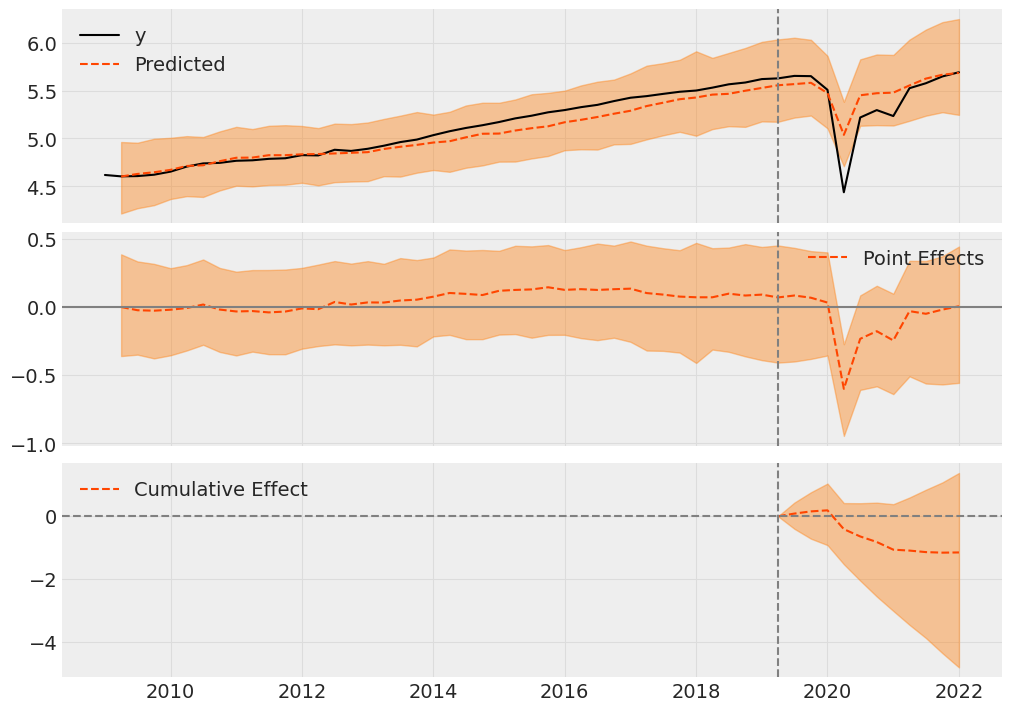

In [13]:
impact.plot()

In [14]:
impact.inferences.head()

,complete_preds_means,complete_preds_lower,complete_preds_upper,post_preds_means,post_preds_lower,post_preds_upper,post_cum_y,post_cum_preds_means,post_cum_preds_lower,post_cum_preds_upper,point_effects_means,point_effects_lower,point_effects_upper,post_cum_effects_means,post_cum_effects_lower,post_cum_effects_upper
Time,,,,,,,,,,,,,,,,
2009-01-01,4.205829,2.607064,5.808424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412982,-1.189614,2.011746,NaN,NaN,NaN
2009-04-01,4.602756,4.216343,4.963045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001554,-0.358735,0.387967,NaN,NaN,NaN
2009-07-01,4.629580,4.271330,4.955631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022360,-0.348411,0.335890,NaN,NaN,NaN
2009-10-01,4.647168,4.303482,4.997397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.025648,-0.375877,0.318038,NaN,NaN,NaN
2010-01-01,4.672311,4.367616,5.006953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018511,-0.353153,0.286184,NaN,NaN,NaN


The getting started notebook had the following helper functions (maybe they should make this part of the library?):

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

def plot_time_series_components(ci):
    # https://github.com/tensorflow/probability/blob/v0.16.0/tensorflow_probability/python/sts/decomposition.py#L165-L195
    component_dists = tfp.sts.decompose_by_component(ci.model, ci.observed_time_series, ci.model_samples)
    num_components = len(component_dists)
    xs = np.arange(len(ci.observed_time_series))
    fig = plt.figure(figsize=(12, 3 * num_components))
    mu, sig = ci.mu_sig if ci.mu_sig is not None else 0.0, 1.0
    for i, (component, component_dist) in enumerate(component_dists.items()):
        # If in graph mode, replace `.numpy()` with `.eval()` or `sess.run()`.
        component_mean = component_dist.mean().numpy()
        component_stddev = component_dist.stddev().numpy()
        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(xs, component_mean, lw=2)
        ax.fill_between(xs,
                        component_mean - 2 * component_stddev,
                        component_mean + 2 * component_stddev,
                        alpha=0.5)
        ax.set_title(component.name)
        

def plot_forecast_components(ci):
    component_forecasts = tfp.sts.decompose_forecast_by_component(ci.model, ci.posterior_dist, ci.model_samples)
    num_components = len(component_forecasts)
    xs = np.arange(len(ci.post_data))
    fig = plt.figure(figsize=(12, 3 * num_components))
    mu, sig = ci.mu_sig if ci.mu_sig is not None else 0.0, 1.0
    for i, (component, component_dist) in enumerate(component_forecasts.items()):
        # If in graph mode, replace `.numpy()` with `.eval()` or `sess.run()`.
        component_mean = component_dist.mean().numpy()
        component_stddev = component_dist.stddev().numpy()
        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(xs, component_mean, lw=2)
        ax.fill_between(xs,
                        component_mean - 2 * component_stddev,
                        component_mean + 2 * component_stddev,
                        alpha=0.5)
        ax.set_title(component.name)

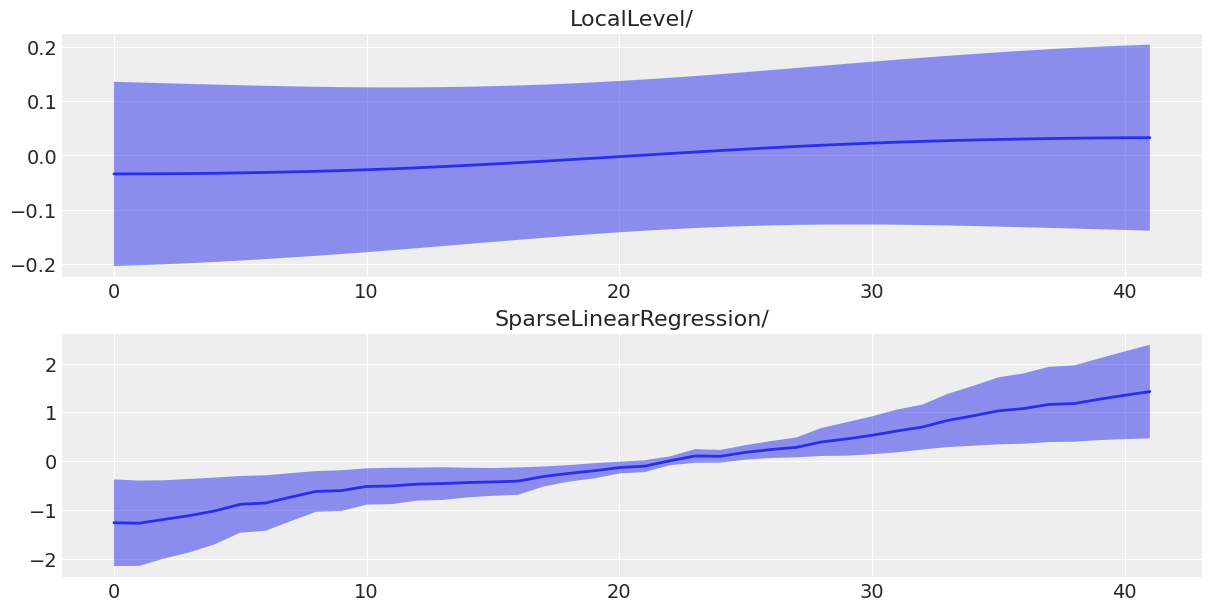

In [16]:
plot_time_series_components(impact)

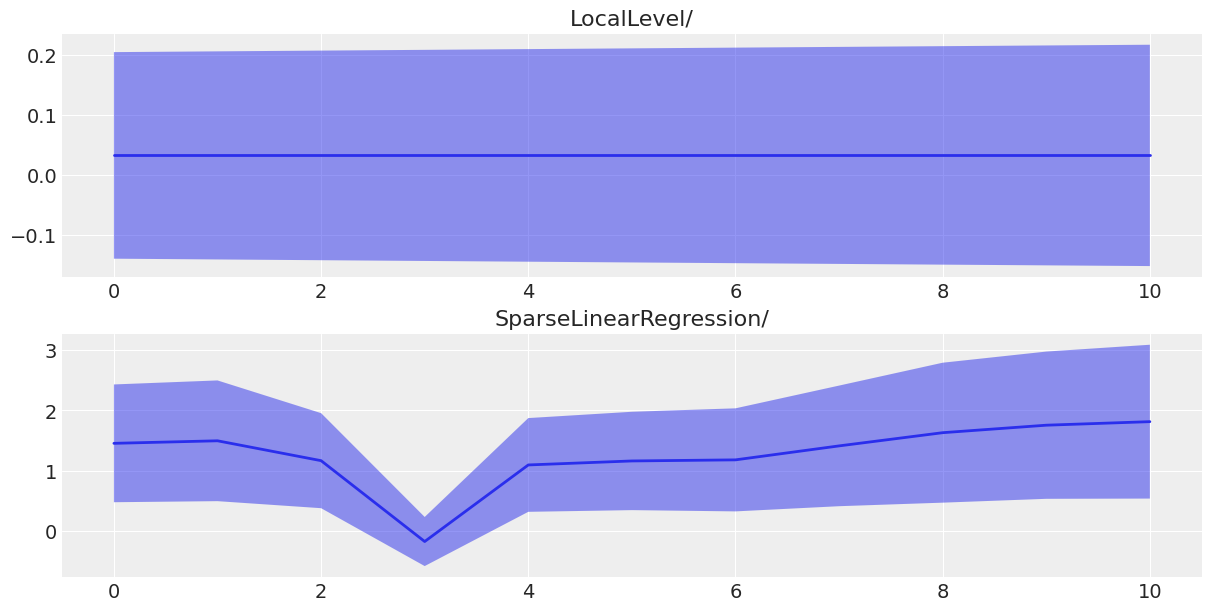

In [17]:
plot_forecast_components(impact)

## Impressions

I like that it uses a BSTS and if I knew more about `tensorflow_probability` this would be great, but unfortunately I don't know tfp so that functionality is lost on me. This library also hasn't had much activity in the last few years and it appears to be happy to copy the `R` package functionality while `CausalPy` has a roadmap of things that they want to include. Since `CausalPy` is backed by the makers of `PyMC` and they just added the state space models to `pymc-experimental`, I'd expect `CausalPy` to be able to support BSTS at some point in the future.

## References

* [Inferring causal impact using Bayesian structural time-series models](https://research.google/pubs/pub41854/)
* [Towards Data Science - Implementing Causal Impact on top of Tensorflow Probability](https://towardsdatascience.com/implementing-causal-impact-on-top-of-tensorflow-probability-c837ea18b126)
* [Inferring the effect of an event using CausalImpact by Kay Broderson](https://www.youtube.com/watch?v=GTgZfCltMm8)
* [tfcausalimpact Getting Started notebook](https://github.com/WillianFuks/tfcausalimpact/blob/master/notebooks/getting_started.ipynb)
* [Unoffical Google Data Science Blog: Fitting Bayesian Structural Time Series](https://www.unofficialgoogledatascience.com/2017/07/fitting-bayesian-structural-time-series.html#:~:text=A%20structural%20time%20series%20model,t%CE%B1t%2B%CF%B5t.)